In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:100%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:12pt;}
div.text_cell_render.rendered_html{font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:5px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [1]:
import numpy as np
import pandas as pd
import os

from tensorflow.keras.datasets import mnist # mnist 훈련셋과 테스트셋
from tensorflow.keras.models import Sequential # 모델 객체 생성
from tensorflow.keras.utils import to_categorical # 분류분석시 y데이터 원핫인코딩
from tensorflow.keras.layers import Input, Dense, Dropout # 모델 layer 쌓을 때 필요. 과적합시 필요
from tensorflow.keras.layers import LeakyReLU # leakyrelu는 activation='relu'처럼 leakyrelu 그대로 쓸 수 없고 %를 작성해줘야해서 import필요
from tensorflow.keras.metrics import Recall, Precision # accuracy 외에 정밀도, 재현율 설정
from tensorflow.keras.models import save_model, load_model # 모델 저장, 로드
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint # 로그출력 간소화, epoch다 돌아가기 전에 괜찮으면 끝내는것

from sklearn.preprocessing import StandardScaler, MinMaxScaler # 정규화, 표준화
from sklearn.metrics import confusion_matrix # 혼동행렬, 교차표
from sklearn.model_selection import train_test_split # 데이터 분리

import matplotlib.pyplot as plt

# red wine 품질 등급 예측


- 1. 데이터셋 확보 & 전처리
    - 독립변수와 타겟변수 분리 → 독립변수 스케일조정(StandardScaler) → 타겟변수원핫인코딩(get_dumies) → 훈련셋과 테스트셋 분리(train_test_split)
- 2. 모델 구성(입력 11, 출력 ?)
- 3. 모델 학습과정 설정(다중분류로 설정)
- 4. 모델 학습(callbacks 이용)
- 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표
- 6. 모델 저장 / 사용



## 1. 데이터셋 확보 & 전처리

- 독립변수와 타겟변수 분리 → 독립변수 스케일조정(StandardScaler) → 타겟변수원핫인코딩(get_dumies) → 훈련셋과 테스트셋 분리(train_test_split)

In [2]:
# 데이터 읽어오기

# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)

'''
고정 산도(fixed acidity)
휘발성 산도(volatile acidity)
구연산(citric acid)
잔여 당분(residual sugar)
염화물(chlorides)
유리 아황산염(free sulfur dioxide)
총 아황산염(total sulfur dioxide)
밀도(density)
pH
황산염(sulphates)
알코올(alcohol)
'''

redwine = pd.read_csv('data/winequality-red.csv', sep=';')
redwine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
redwine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
# 타겟변수의 균형
# value_counts(normalize=True) : 데이터프레임 열의 고유값별 개수가 아닌, 각 고유값이 전체에서 차지하는 비율(비중)을 반환하는 함수

redwine['quality'].value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [5]:
# 독립변수, 타겟변수 분리

X_redwine = redwine.iloc[:, :-1].values # to_numpy와 유사. numpy배열로
y_redwine = redwine.iloc[:, -1] # 3~8등급까지 있음
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [6]:
# 독립변수 X의 스케일 조정
scaler = StandardScaler()
scaled_X_redwine = scaler.fit_transform(X_redwine)

# 다중분류를 위한 타겟변수의 원핫인코딩 → numpy배열로 변환
Y_redwine = pd.get_dummies(y_redwine).to_numpy()

In [7]:
# 독립변수 : scaled_X_redwine & 타겟변수 : Y_redwine

scaled_X_redwine.shape, Y_redwine.shape

((1599, 11), (1599, 6))

In [8]:
print('원데이터 ▶ 원핫인코딩')

# 원핫인코딩한 0번째 인덱스가 3등급(get_dummies()사용)
# 원데이터  3, 4, 5, 6, 7, 8
#       6, 0, 0, 0, 1, 0, 0
np.column_stack([y_redwine[3:5], Y_redwine[3:5]]) 

원데이터 ▶ 원핫인코딩


array([[6, 0, 0, 0, 1, 0, 0],
       [5, 0, 0, 1, 0, 0, 0]], dtype=int64)

In [9]:
# 훈련셋과 테스트셋 분리(층화추출) = 7:3

X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine, Y_redwine,
                                                    test_size=0.3,      # train_size=0.7 이랑 같음
                                                    stratify=Y_redwine) # 층화추출 

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((1119, 11), (1119, 6), (480, 11), (480, 6))

In [10]:
redwine['quality'].value_counts(normalize=True) # 데이터프레임, 시리즈에만 쓸 수 있음. 위의 것들 비율을 알고싶은데 X_train들은 넘파이배열

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

In [11]:
# 그래서 비율을 알고싶으면 시리즈로 한번 감싸야함. np.c_ == np.column_stack
# 층화추출이 잘 되었는지 보고자 한 과정

np.c_[pd.Series(Y_redwine.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_train.argmax(axis=1)).value_counts(normalize=True),
      pd.Series(Y_test.argmax(axis=1)).value_counts(normalize=True)]

array([[0.42589118, 0.42627346, 0.425     ],
       [0.39899937, 0.39857015, 0.4       ],
       [0.12445278, 0.12421805, 0.125     ],
       [0.03314572, 0.03306524, 0.03333333],
       [0.01125704, 0.01161752, 0.01041667],
       [0.00625391, 0.00625559, 0.00625   ]])

## 2. 모델구성(입력 11, 출력 6)

In [50]:
model = Sequential()
model.add(Input(11)) # Input(shape=(11,))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation='relu'))
model.add(Dense(units=6, activation='softmax')) # softmax 합한값이 1. 우리는 비율이 다 합쳤을때 100%여야하니까 마지막층 softmax
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 50)                600       
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_26 (Dense)            (None, 30)                1530      
                                                                 
 dense_27 (Dense)            (None, 6)                 186       
                                                                 
Total params: 4,866
Trainable params: 4,866
Non-trainable params: 0
_________________________________________________________________


## 3. 모델과정 설정(다중분류에 맞는 설정)

## 4. 학습시키기(callbacks 이용)

In [51]:
%%time

# 학습과정 설정
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

# 로그 출력
class CustomHistory(Callback): # on_epoch_end()함수가 1epoch마다 수행 후 자동호출.
    def __init__(self):
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if (self.epoch%5 == 0) | (self.epoch == 1):
            print('{}번째 loss:{:.4f}, acc:{:.4f}, val_loss{:.4f}, val_accuracy{:.4f}'\
                  .format(self.epoch, logs.get('loss'), logs.get('accuracy'), logs.get('val_loss'), logs.get('val_accuracy')))

# 저장경로 설정
model_save_folder = 'model/wine/'
if not os.path.exists(model_save_folder): # 폴더없으면 폴더생성
    os.mkdir(model_save_folder)
file = model_save_folder + 'wine-{epoch:03d}-loss{val_loss:.4f}-acc{val_accuracy:.4f}.h5'

# 콜백 객체생성
customHistory = CustomHistory()
checkpoint = ModelCheckpoint(filepath=file, 
                             monitor='val_accuracy', # val_accuracy가 좋아질때마다 저장하라는말. 모니터링 지표 : loss, val_loss, accuracy 
                             save_best_only=True,    # 모니터링 지표가 개선된 경우만 저장
                             mode='max',
                             verbose=0)              # 로그출력 여부. customHistory로 출력할것이기에 꺼둔것
earlyStopping = EarlyStopping(monitor='val_loss', 
                              patience=20)

# 학습
hist = model.fit(X_train, Y_train,
                 epochs=200,
                 batch_size=200,
                 validation_split=0.2, # 학습셋의 20%는 검증셋으로 쓰겠다
                 verbose=0,            # 로그출력 막음(콜백함수에서 출력)
                 callbacks=[customHistory, checkpoint, earlyStopping])



1번째 loss:1.6819, acc:0.2346, val_loss1.6333, val_accuracy0.3616
5번째 loss:1.2588, acc:0.4760, val_loss1.3305, val_accuracy0.4062
10번째 loss:1.0504, acc:0.5743, val_loss1.2239, val_accuracy0.5268
15번째 loss:0.9611, acc:0.6056, val_loss1.1577, val_accuracy0.5759
20번째 loss:0.9211, acc:0.6156, val_loss1.1443, val_accuracy0.5938
25번째 loss:0.8895, acc:0.6335, val_loss1.1176, val_accuracy0.6205
30번째 loss:0.8623, acc:0.6525, val_loss1.1125, val_accuracy0.6027
35번째 loss:0.8453, acc:0.6581, val_loss1.1018, val_accuracy0.5982
40번째 loss:0.8167, acc:0.6693, val_loss1.0886, val_accuracy0.5893
45번째 loss:0.7889, acc:0.6939, val_loss1.0926, val_accuracy0.5848
50번째 loss:0.7711, acc:0.6916, val_loss1.0778, val_accuracy0.5938
55번째 loss:0.7633, acc:0.7084, val_loss1.0671, val_accuracy0.5938
60번째 loss:0.7519, acc:0.6905, val_loss1.0638, val_accuracy0.5938
65번째 loss:0.7211, acc:0.7128, val_loss1.0604, val_accuracy0.6027
70번째 loss:0.7038, acc:0.7117, val_loss1.0567, val_accuracy0.5938
75번째 loss:0.6941, acc:0.724

## 5. 모델 평가

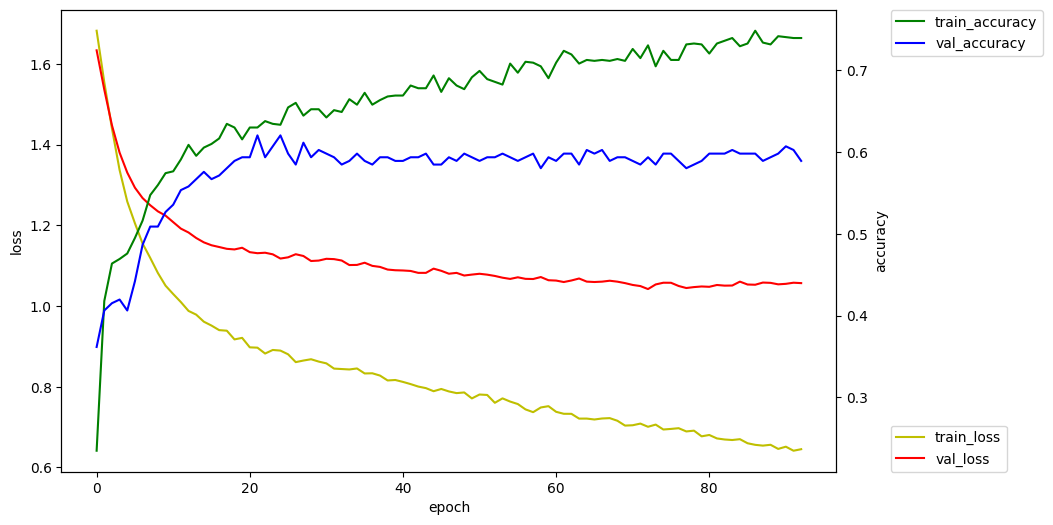

In [52]:
# 학습과정 표시하기

fig, loss_ax = plt.subplots(figsize=(10,6))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')

acc_ax = loss_ax.twinx() # loss_ax와 x축을 공유하는 acc_ax생성
acc_ax.plot(hist.history['accuracy'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val_accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(bbox_to_anchor=(1.07, 0.1), loc=2, borderaxespad=0.)
acc_ax.legend(bbox_to_anchor=(1.07, 1), loc=2, borderaxespad=0.)
plt.show()

In [53]:
# 모델 평가

loss_and_acc = model.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc[0]:.4f}, accuracy:{loss_and_acc[1]:.4f}')

loss:1.1109, accuracy:0.5583


In [48]:
model1 = load_model('model/wine/wine-096-loss1.0395-acc0.6295.h5')
loss_and_acc1 = model1.evaluate(X_test, Y_test, batch_size=100, verbose=0)
print(f'loss:{loss_and_acc1[0]:.4f}, accuracy:{loss_and_acc1[1]:.4f}')

loss:1.0690, accuracy:0.5708


In [54]:
model1.save('model/wine/wine.h5')

In [60]:
# 교차표(실제값과 예측값을 1차원 데이터로)

# 실제값
# real = np.argmax(Y_test, axis=1)
real = Y_test.argmax(axis=1) + 3 # get_dummies를 썼기때문에 해줘야함.

#예측값
# pred = np.argmax(model1.predict(X_test), axis=1)
pred = model1.predict(X_test).argmax(axis=1) + 3

# 교차표
pd.crosstab(real, pred, rownames=['real'], colnames=['predict'])

15/15 [==============================] - 0s 997us/step


predict,4,5,6,7
real,,,,
3,0,3,0,0
4,0,10,4,2
5,1,152,47,4
6,0,68,102,22
7,0,4,36,20
8,0,0,4,1


## 6. 모델 사용

In [61]:
X_redwine[0]

array([ 7.4   ,  0.7   ,  0.    ,  1.9   ,  0.076 , 11.    , 34.    ,
        0.9978,  3.51  ,  0.56  ,  9.4   ])

In [66]:
input_data = [ 7.4, 0.7, 0., 1.9, 0.076, 11., 34., 0.9978, 3.51, 0.56, 9.4]
scaled_data = scaler.transform([input_data])
model1.predict(scaled_data).argmax(axis=1) + 3

1/1 [==============================] - 0s 15ms/step


array([5], dtype=int64)